In [5]:
# from tensorflow.keras.applications.resnet50 import preprocess_input
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications.resnet50 import ResNet50
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt
import numpy as np
import cv2
import scipy
from scipy import ndimage

In [6]:
import pandas as pd
df = pd.read_csv('../data/annotations/list.txt', skiprows=6, delimiter=" ", names=["image_name", "class_id", "species", "breed_id"])

In [7]:
df

,image_name,class_id,species,breed_id
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1
...,...,...,...,...
7344,yorkshire_terrier_96,37,2,25
7345,yorkshire_terrier_97,37,2,25
7346,yorkshire_terrier_98,37,2,25
7347,yorkshire_terrier_99,37,2,25


In [8]:
df["category"] = ""
df.loc[(df["species"]==1) & (df["breed_id"]>=1) & (df["breed_id"]<=12), "category"] = "cat"
df.loc[(df["species"]==2) & (df["breed_id"]>=1) & (df["breed_id"]<=25), "category"] = "dog"

In [9]:
df

,image_name,class_id,species,breed_id,category
0,Abyssinian_100,1,1,1,cat
1,Abyssinian_101,1,1,1,cat
2,Abyssinian_102,1,1,1,cat
3,Abyssinian_103,1,1,1,cat
4,Abyssinian_104,1,1,1,cat
...,...,...,...,...,...
7344,yorkshire_terrier_96,37,2,25,dog
7345,yorkshire_terrier_97,37,2,25,dog
7346,yorkshire_terrier_98,37,2,25,dog
7347,yorkshire_terrier_99,37,2,25,dog


In [10]:
import os
annotations_dir=r'../data/annotations/trimaps'
img_dir=r'../data/images'
img_files = [f for f in os.listdir(annotations_dir) if not f.startswith('._') and f.endswith('.png')]

In [11]:
final=[]
for i in range(len(img_files)):
    try:
        k=str(df.loc[df['image_name']==img_files[i][:-4]]['category'].values[0])
        final.append([img_files[i],k])
    except:
        pass

In [12]:
# import shutil
# images = []
# masks=[]
# i=0
# j=0
# categorized_img_dir = os.path.join(img_dir, 'categorized', 'images')
# categorized_mask_dir = os.path.join(img_dir, 'categorized', 'masks')

# if not os.path.exists(categorized_img_dir):
#     os.makedirs(categorized_img_dir)
# if not os.path.exists(categorized_mask_dir):
#     os.makedirs(categorized_mask_dir)

# for f in final:
#     mask_img_path = os.path.join(annotations_dir, f[0])
#     img_path=os.path.join(img_dir, f[0]).replace(".png", ".jpg")

#     if f[1]=='cat': 
#         if os.path.exists(categorized_img_dir+'\\'+f[1]+'_'+str(i)+'.jpg'):
#             i+=1
#         shutil.copy2(img_path,os.path.join(categorized_img_dir, f"cat_{i}.jpg"))
#         shutil.copy2(mask_img_path,os.path.join(categorized_mask_dir, f"cat_{i}.jpg"))
#     else:
#         if os.path.exists(categorized_img_dir+'\\'+f[1]+'_'+str(j)+'.jpg'):
#             j+=1
#         shutil.copy2(img_path,os.path.join(categorized_img_dir, f"dog_{j}.jpg"))
#         shutil.copy2(mask_img_path,os.path.join(categorized_mask_dir, f"dog_{j}.jpg"))
        

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
categorized_img_dir = os.path.join(img_dir, 'categorized', 'images')
categorized_mask_dir = os.path.join(img_dir, 'categorized', 'masks')
IMG_DIR=categorized_img_dir
MASK_DIR=categorized_mask_dir
training_data=[]
mask_data=[]

def train_data():
    for img in os.listdir(IMG_DIR):
        try:
            img_array = cv2.resize(cv2.cvtColor(cv2.imread(os.path.join(IMG_DIR,img)), cv2.COLOR_BGR2RGB), (128,128))
            
            mask_array=cv2.resize(cv2.imread(os.path.join(MASK_DIR,img),cv2.IMREAD_GRAYSCALE), (128,128))
           
            training_data.append(img_array)
            mask_data.append(mask_array)
        except Exception as e:
            pass
train_data()

In [14]:
def preprocess_data(training_data,masks):
    images=np.array(training_data)
    images=images.astype('float64')
    masks=np.array(mask_data)
    masks=masks.astype('float64')
    masks[masks==3]=255
    masks[masks==1]=255
    masks[masks==2]=0
    kernel = np.ones((3,3))
    for i in range(len(masks)):
        masks[i] = cv2.morphologyEx(masks[i], cv2.MORPH_CLOSE, kernel)
    images/=255
    masks/=255
    return images,masks

images,masks=preprocess_data(training_data,mask_data)

In [15]:
print(images.shape)
print(masks.shape)

(7349, 128, 128, 3)
(7349, 128, 128)


In [16]:
combined = list(zip(images, masks))
random.seed(42)
random.shuffle(combined)
images[:], masks[:] = zip(*combined)

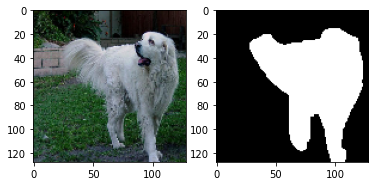

In [17]:
plt.subplot(121)
plt.imshow(images[2000])
plt.subplot(122)
plt.imshow(masks[2000],'gray')
plt.show()

In [18]:
train_size=int(images.shape[0]*0.6)
test_size=int(images.shape[0]*0.2)
validation_size=int(images.shape[0]*0.2)

Xtrain=images[:train_size]
ytrain=masks[:train_size]

Xval=images[train_size:train_size+validation_size]
yval=masks[train_size:train_size+validation_size]

Xtest=images[train_size+validation_size:]
ytest=masks[train_size+validation_size:]

print(Xtrain.shape)
print(ytrain.shape)
print()
print(Xval.shape)
print(yval.shape)
print()
print(Xtest.shape)
print(ytest.shape)

(4409, 128, 128, 3)
(4409, 128, 128)

(1469, 128, 128, 3)
(1469, 128, 128)

(1471, 128, 128, 3)
(1471, 128, 128)


In [19]:
bound_df = pd.read_csv('../data/gt_label.txt', delimiter=" ", names=["x", "y", "h", "w","category"])

In [156]:

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import pickle 
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers,Sequential
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2DTranspose, concatenate, Activation, LeakyReLU,BatchNormalization,Conv2D,add
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam,SGD,Adagrad
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input,Dropout,add,BatchNormalization
import numpy as np
from tensorflow.keras.losses import BinaryCrossentropy


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization_35 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
leaky_re_lu_35 (LeakyReLU)   (None, 128, 128, 32)      0         
_________________________________________________________________
dropout_85 (Dropout)         (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 64, 64, 64)        1849

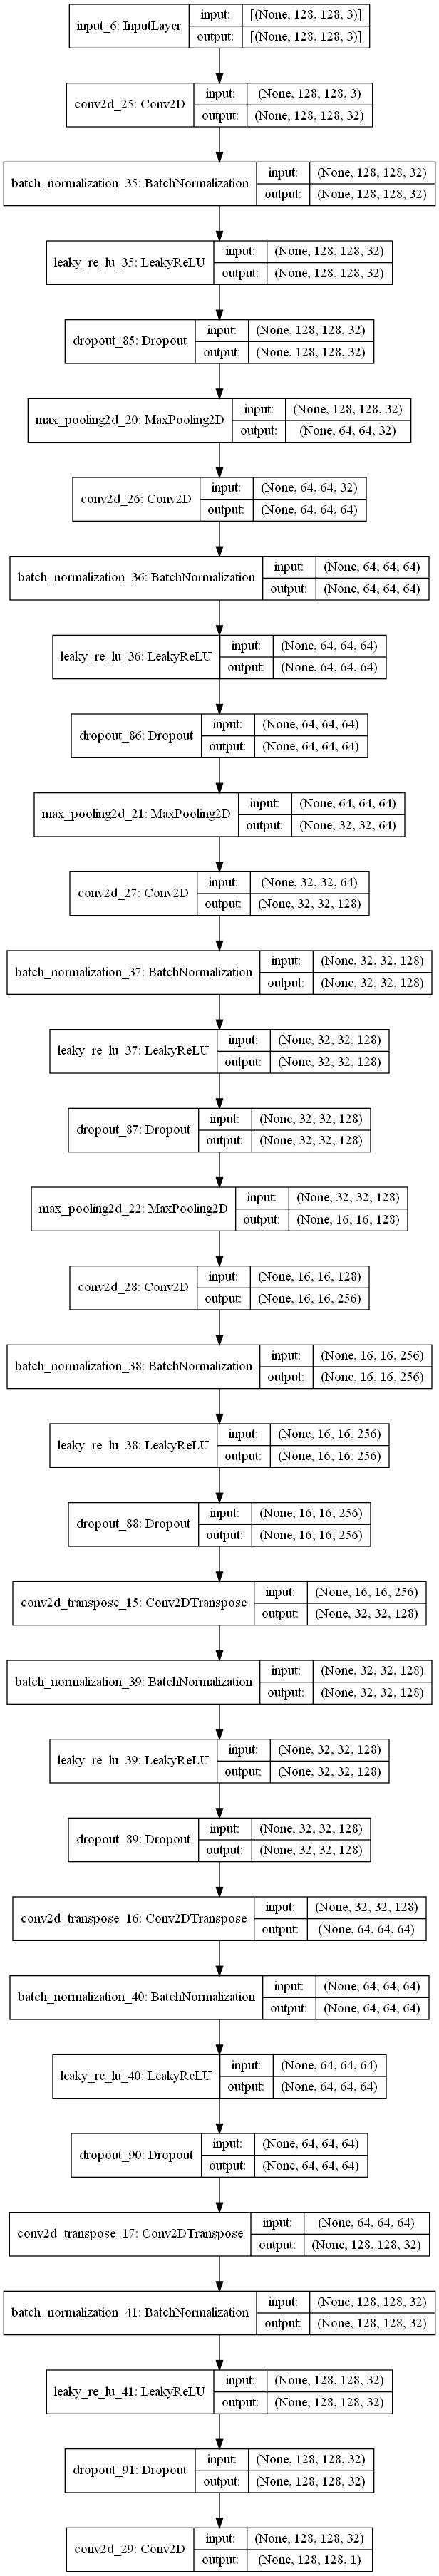

In [164]:
def build_model():
  input_image = Input(shape=(128,128,3))

  conv1=Conv2D(32,3,padding='same')(input_image)
  conv1=BatchNormalization()(conv1)
  conv1=LeakyReLU()(conv1)
  conv1=Dropout(0.25)(conv1)
  pool1=MaxPooling2D((2,2))(conv1)

  conv2=Conv2D(64,3,padding='same')(pool1)
  conv2=BatchNormalization()(conv2)
  conv2=LeakyReLU()(conv2)
  conv2=Dropout(0.25)(conv2)
  pool2=MaxPooling2D((2,2))(conv2)

  conv3=Conv2D(128,3,padding='same')(pool2)
  conv3=BatchNormalization()(conv3)
  conv3=LeakyReLU()(conv3)
  conv3=Dropout(0.25)(conv3)
  pool3=MaxPooling2D((2,2))(conv3)


  #middle block
  middle_layer=Conv2D(256,(3,3),padding='same')(pool3)
  middle_layer=BatchNormalization()(middle_layer)
  middle_layer=LeakyReLU()(middle_layer)
  middle_layer=Dropout(0.25)(middle_layer)
  middle_pool=MaxPooling2D((2,2))(middle_layer)


  deconv3=tf.keras.layers.Conv2DTranspose(128,(3,3),2,padding='same')(middle_layer)
  deconv3=BatchNormalization()(deconv3)
  deconv3=LeakyReLU()(deconv3)
  deconv3=Dropout(0.25)(deconv3)


  deconv2=tf.keras.layers.Conv2DTranspose(64,(3,3),2,padding='same')(deconv3)
  deconv2=BatchNormalization()(deconv2)
  deconv2=LeakyReLU()(deconv2)
  deconv2=Dropout(0.25)(deconv2)



  deconv1=tf.keras.layers.Conv2DTranspose(32,(3,3),2,padding='same')(deconv2)
  deconv1=BatchNormalization()(deconv1)
  deconv1=LeakyReLU()(deconv1)
  deconv1=Dropout(0.25)(deconv1)

  output = Conv2D(1,(3,3),padding='same',activation='sigmoid')(deconv1)

  model = Model(inputs=[input_image],outputs=[output])
  return model

segmentation_model=build_model()
segmentation_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=BinaryCrossentropy(), metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])
segmentation_model.summary()
tf.keras.utils.plot_model(segmentation_model,show_shapes=True)


In [165]:
callbacks=[tf.keras.callbacks.ModelCheckpoint("best_model_noskip.h5",save_best_only=True,monitor='val_mean_io_u_5', mode='max')]

In [166]:
segmentation_model1_history=segmentation_model.fit(Xtrain,ytrain,epochs=25,callbacks=callbacks,batch_size=32,validation_data=(Xval,yval))

Epoch 1/25
138/138 [==============================] - 120s 835ms/step - loss: 0.5876 - mean_io_u_5: 0.2992 - val_loss: 1.1319 - val_mean_io_u_5: 0.2991
Epoch 2/25
138/138 [==============================] - 140s 1s/step - loss: 0.4396 - mean_io_u_5: 0.2992 - val_loss: 0.5094 - val_mean_io_u_5: 0.2991
Epoch 3/25
138/138 [==============================] - 137s 995ms/step - loss: 0.4060 - mean_io_u_5: 0.2992 - val_loss: 1.3833 - val_mean_io_u_5: 0.2991
Epoch 4/25
138/138 [==============================] - 123s 893ms/step - loss: 0.3829 - mean_io_u_5: 0.2992 - val_loss: 0.8321 - val_mean_io_u_5: 0.2991
Epoch 5/25
138/138 [==============================] - 120s 868ms/step - loss: 0.3586 - mean_io_u_5: 0.2992 - val_loss: 0.5603 - val_mean_io_u_5: 0.2991
Epoch 6/25
138/138 [==============================] - 124s 900ms/step - loss: 0.3453 - mean_io_u_5: 0.2992 - val_loss: 0.4008 - val_mean_io_u_5: 0.2991
Epoch 7/25
138/138 [==============================] - 121s 878ms/step - loss: 0.3336 - mean

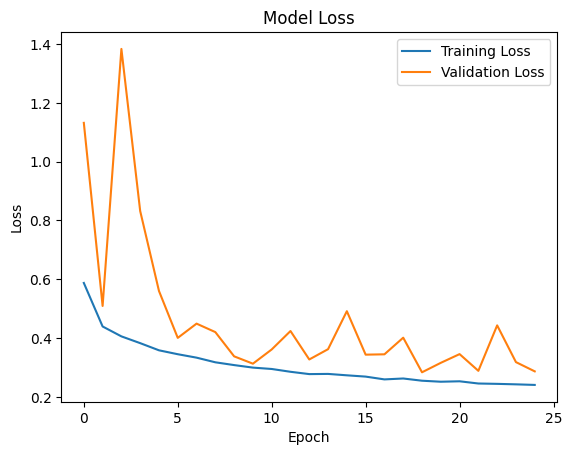

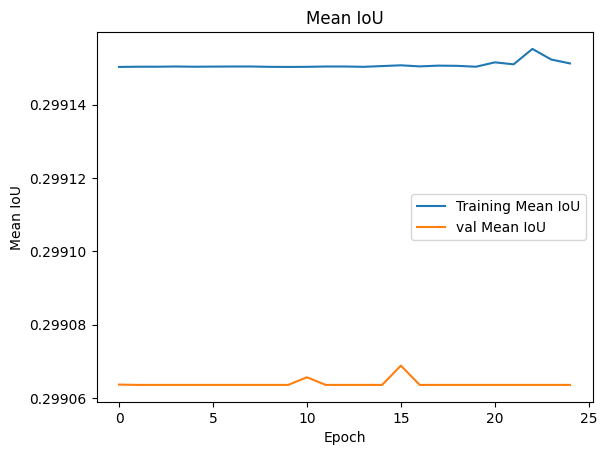

In [167]:
import matplotlib.pyplot as plt

plt.plot(segmentation_model1_history.history['loss'])
plt.plot(segmentation_model1_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()


plt.plot(segmentation_model1_history.history['mean_io_u_5'])
plt.plot(segmentation_model1_history.history['val_mean_io_u_5'])
plt.title('Mean IoU')
plt.xlabel('Epoch')
plt.ylabel('Mean IoU')
plt.legend(['Training Mean IoU', 'val Mean IoU'])
plt.show()


Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_80 (Conv2D)              (None, 128, 128, 32) 896         input_17[0][0]                   
__________________________________________________________________________________________________
batch_normalization_112 (BatchN (None, 128, 128, 32) 128         conv2d_80[0][0]                  
__________________________________________________________________________________________________
dropout_162 (Dropout)           (None, 128, 128, 32) 0           batch_normalization_112[0][0]    
___________________________________________________________________________________________

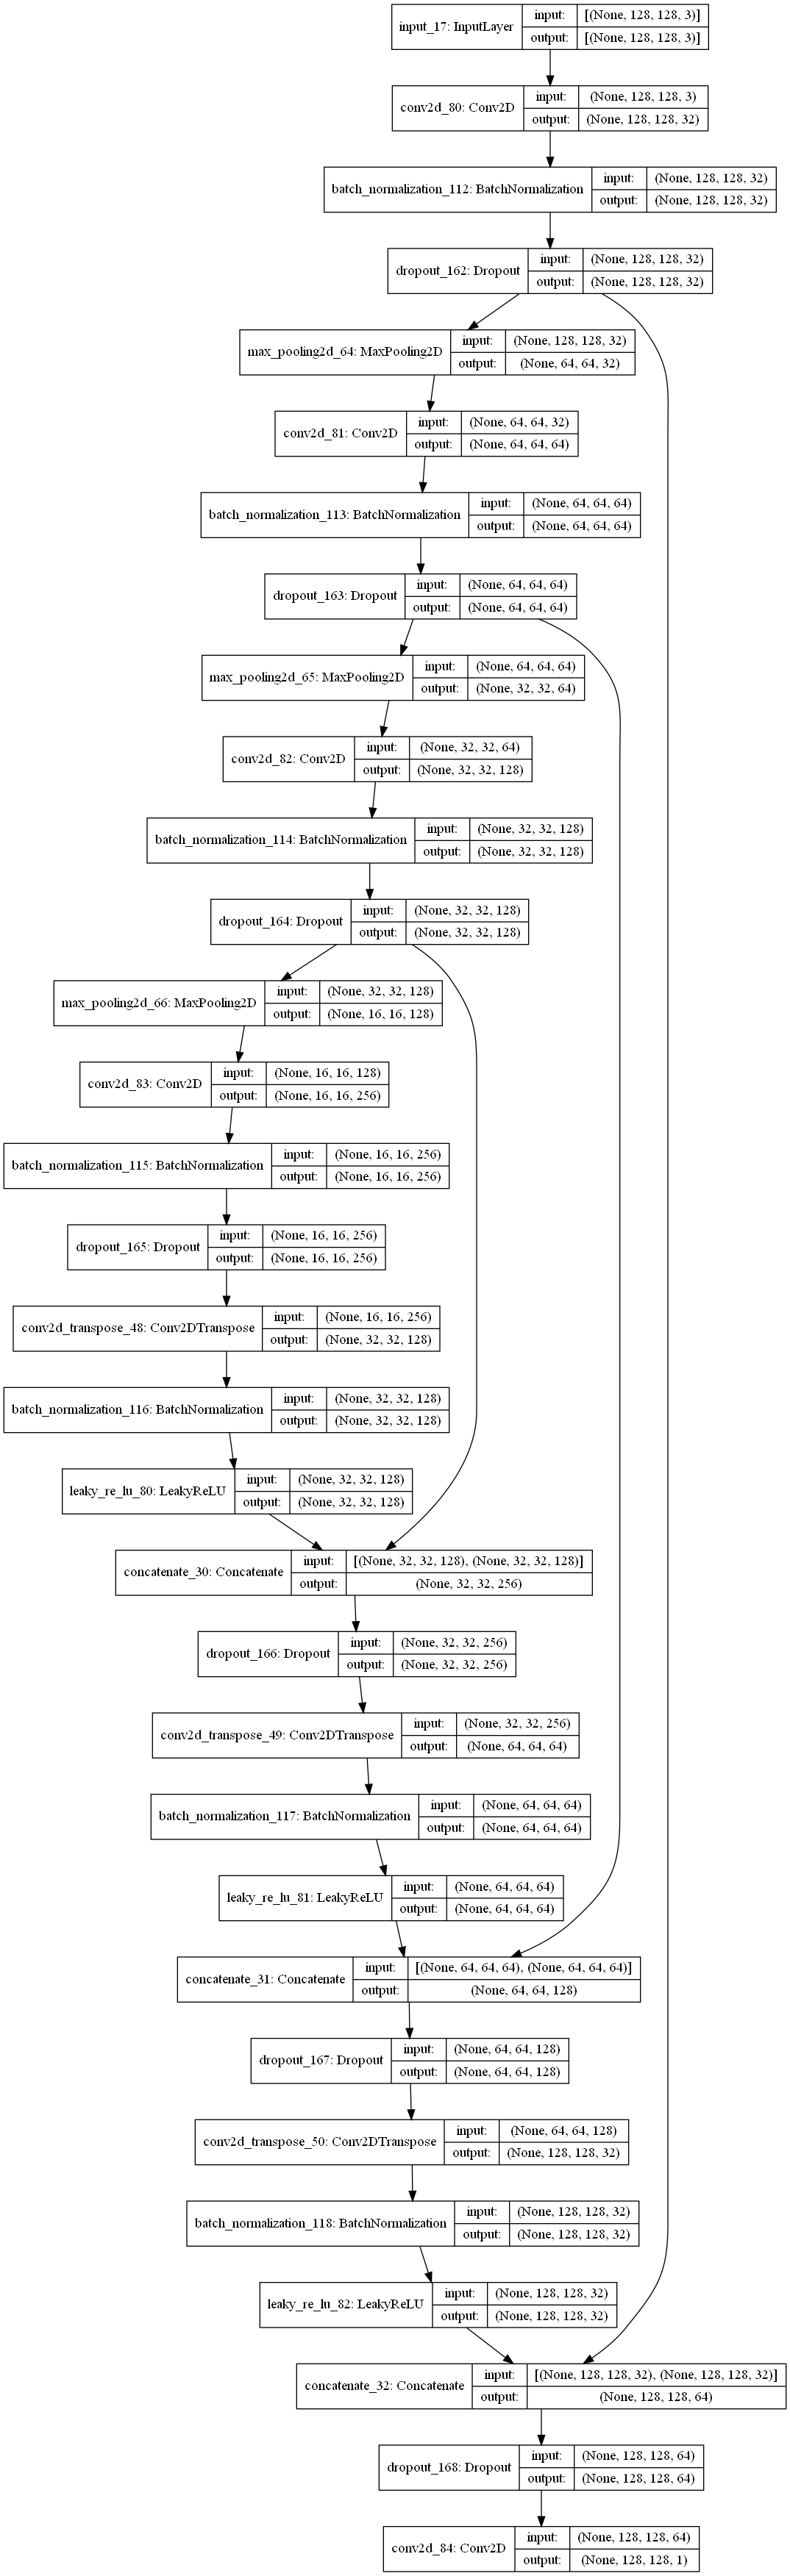

In [206]:
def build_model():
  input_image = Input(shape=(128,128,3))

  conv1=Conv2D(32,3,padding='same',activation='relu')(input_image)
  conv1=BatchNormalization()(conv1)
#   conv1=LeakyReLU()(conv1)
  conv1=Dropout(0.25)(conv1)
  pool1=MaxPooling2D((2,2))(conv1)

  conv2=Conv2D(64,3,padding='same',activation='relu')(pool1)
  conv2=BatchNormalization()(conv2)
#   conv2=LeakyReLU()(conv2)
  conv2=Dropout(0.25)(conv2)
  pool2=MaxPooling2D((2,2))(conv2)

  conv3=Conv2D(128,3,padding='same',activation='relu')(pool2)
  conv3=BatchNormalization()(conv3)
#   conv3=LeakyReLU()(conv3)
  conv3=Dropout(0.25)(conv3)
  pool3=MaxPooling2D((2,2))(conv3)




  #middle block
  middle_layer=Conv2D(256,(3,3),padding='same',activation='relu')(pool3)
  middle_layer=BatchNormalization()(middle_layer)
#   middle_layer=LeakyReLU()(middle_layer)
  middle_layer=Dropout(0.25)(middle_layer)





  deconv3=tf.keras.layers.Conv2DTranspose(128,(3,3),2,padding='same')(middle_layer)
  deconv3=BatchNormalization()(deconv3)
  deconv3=LeakyReLU()(deconv3)
  deconv3=concatenate([deconv3,conv3])
  deconv3=Dropout(0.25)(deconv3)

  deconv2=tf.keras.layers.Conv2DTranspose(64,(3,3),2,padding='same')(deconv3)
  deconv2=BatchNormalization()(deconv2)
  deconv2=LeakyReLU()(deconv2)
  deconv2=concatenate([deconv2,conv2])
  deconv2=Dropout(0.25)(deconv2)


  deconv1=tf.keras.layers.Conv2DTranspose(32,(3,3),2,padding='same')(deconv2)
  deconv1=BatchNormalization()(deconv1)
  deconv1=LeakyReLU()(deconv1)
  deconv1=concatenate([deconv1,conv1])
  deconv1=Dropout(0.25)(deconv1)

  output = Conv2D(1,(3,3),padding='same',activation='sigmoid')(deconv1)

  model = Model(inputs=[input_image],outputs=[output])
  return model

segmentation_model2=build_model()
segmentation_model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss=BinaryCrossentropy(), metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])
segmentation_model2.summary()
tf.keras.utils.plot_model(segmentation_model2,show_shapes=True)


In [207]:
callbacks=[tf.keras.callbacks.ModelCheckpoint("best_model_skip.h5",save_best_only=True,monitor='val_mean_io_u_16', mode='max')]

In [208]:
segmentation_model2_history=segmentation_model2.fit(Xtrain,ytrain,epochs=25,callbacks=callbacks,batch_size=16,validation_data=(Xval,yval))

Epoch 1/25
276/276 [==============================] - 134s 472ms/step - loss: 0.4637 - mean_io_u_16: 0.2992 - val_loss: 0.9122 - val_mean_io_u_16: 0.2991
Epoch 2/25
276/276 [==============================] - 134s 487ms/step - loss: 0.3771 - mean_io_u_16: 0.2992 - val_loss: 0.5352 - val_mean_io_u_16: 0.2991
Epoch 3/25
276/276 [==============================] - 155s 562ms/step - loss: 0.3476 - mean_io_u_16: 0.2992 - val_loss: 0.4217 - val_mean_io_u_16: 0.2991
Epoch 4/25
276/276 [==============================] - 145s 525ms/step - loss: 0.3218 - mean_io_u_16: 0.2992 - val_loss: 0.4319 - val_mean_io_u_16: 0.2991
Epoch 5/25
276/276 [==============================] - 145s 527ms/step - loss: 0.3101 - mean_io_u_16: 0.2992 - val_loss: 0.4956 - val_mean_io_u_16: 0.2991
Epoch 6/25
276/276 [==============================] - 149s 538ms/step - loss: 0.2961 - mean_io_u_16: 0.2992 - val_loss: 0.3811 - val_mean_io_u_16: 0.2991
Epoch 7/25
276/276 [==============================] - 156s 566ms/step - loss

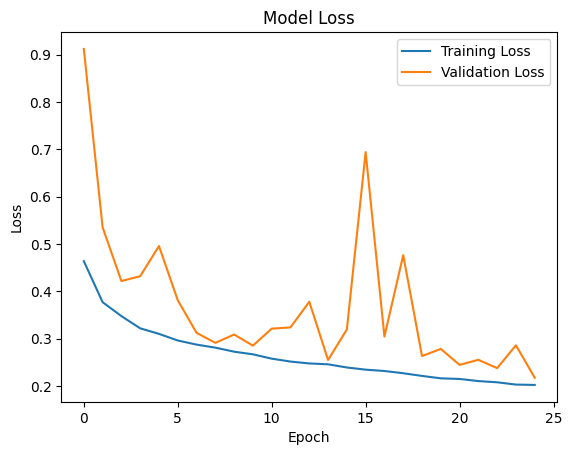

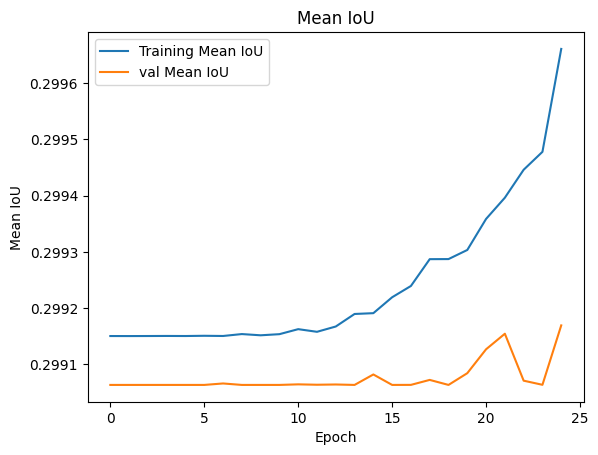

In [209]:
import matplotlib.pyplot as plt

plt.plot(segmentation_model2_history.history['loss'])
plt.plot(segmentation_model2_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()


plt.plot(segmentation_model2_history.history['mean_io_u_16'])
plt.plot(segmentation_model2_history.history['val_mean_io_u_16'])
plt.title('Mean IoU')
plt.xlabel('Epoch')
plt.ylabel('Mean IoU')
plt.legend(['Training Mean IoU', 'val Mean IoU'])
plt.show()


In [279]:
from matplotlib.lines import Real
BATCH_SIZE=32
def preprocess_image1(image):
    return image


def augumentation(real,fake):

  train_ds_one = (
      tf.data.Dataset.from_tensor_slices(real)
      .map(preprocess_image1, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  )
  train_ds_two = (
      tf.data.Dataset.from_tensor_slices(fake)
      .map(preprocess_image1, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  )

  ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))
  train_ds_cmu = (
    ds.shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
  )
  return train_ds_cmu

train_ds=augumentation(np.transpose(Xtrain, (0,3,1,2)),ytrain)
val_ds=augumentation(np.transpose(Xval, (0,3,1,2)),yval)

In [280]:
# pip install transformers -q


In [281]:
from transformers import TFSegformerForSemanticSegmentation


In [282]:
model_checkpoint = "nvidia/mit-b0"
# id2label = {0: "outer", 1: "inner"}
# label2id = {label: id for id, label in id2label.items()}
transformer_model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=2,
    ignore_mismatched_sizes=True,
)

Some layers from the model checkpoint at nvidia/mit-b0 were not used when initializing TFSegformerForSemanticSegmentation: ['classifier']
- This IS expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFSegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [283]:
from IPython.display import clear_output


# def create_mask(pred_mask):
#     pred_mask = tf.math.argmax(pred_mask, axis=1)
#     pred_mask = tf.expand_dims(pred_mask, -1)
#     return pred_mask[0]


# def show_predictions(dataset=None, num=1):
#     if dataset:
#         for sample in dataset.take(num):
#             images, masks = sample["pixel_values"], sample["labels"]
#             masks = tf.expand_dims(masks, -1)
#             pred_masks = model.predict(images).logits
#             images = tf.transpose(images, (0, 2, 3, 1))
#             display([images[0], masks[0], create_mask(pred_masks)])
#     else:
#         display(
#             [
#                 sample_image,
#                 sample_mask,
#                 create_mask(model.predict(tf.expand_dims(sample_image, 0))),
#             ]
#         )

class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, **kwargs):
        super().__init__(**kwargs)
        self.dataset = dataset

    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(self.dataset)
        print("\nSample Prediction after epoch {}\n".format(epoch + 1))

In [284]:
lr = 0.00006
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
transformer_model.compile(optimizer=optimizer)
transformer_model.summary()

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


Model: "tf_segformer_for_semantic_segmentation_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
segformer (TFSegformerMainLa multiple                  3319392   
_________________________________________________________________
decode_head (TFSegformerDeco multiple                  395778    
Total params: 3,715,170
Trainable params: 3,714,658
Non-trainable params: 512
_________________________________________________________________


In [ ]:
epochs = 15

transformer_history = transformer_model.fit(
    train_ds,
    validation_data=val_ds,verbose=1,
    epochs=epochs
)

Epoch 1/15
138/138 [==============================] - 183s 1s/step - loss: 0.2322 - val_loss: 0.1446
Epoch 2/15
138/138 [==============================] - 169s 1s/step - loss: 0.1495 - val_loss: 0.1252
Epoch 3/15
 78/138 [===============>..............] - ETA: 1:06 - loss: 0.1322

In [248]:
model.save_pretrained("./")

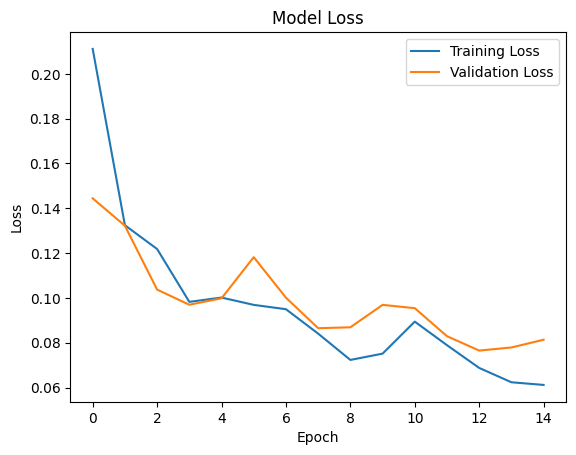

In [249]:
import matplotlib.pyplot as plt

plt.plot(transformer_history.history['loss'])
plt.plot(transformer_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

In [250]:
pred_ds=np.transpose(Xval, (0,3,1,2))

In [251]:
ypred=model.predict(pred_ds)

In [252]:
np.array(ypred[0]).shape

(1469, 2, 32, 32)

In [253]:
ypred=np.transpose(ypred[0],(0,2,3,1))

In [254]:
# ypred.shape

In [255]:
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=3)
#     pred_mask = tf.expand_dims(pred_mask, -1)
    return pred_mask

In [256]:
# tf.expand_dims(ypred, 1).shape

In [257]:
ypred=create_mask(ypred)

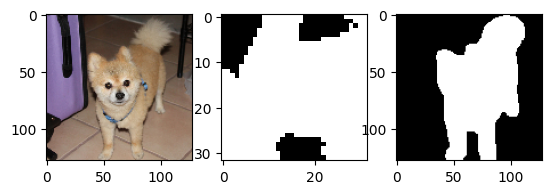

In [258]:
plt.subplot(131)
plt.imshow(Xval[0])
plt.subplot(132)
plt.imshow(ypred[0],'gray')
plt.subplot(133)
plt.imshow(yval[0],'gray')
plt.show()

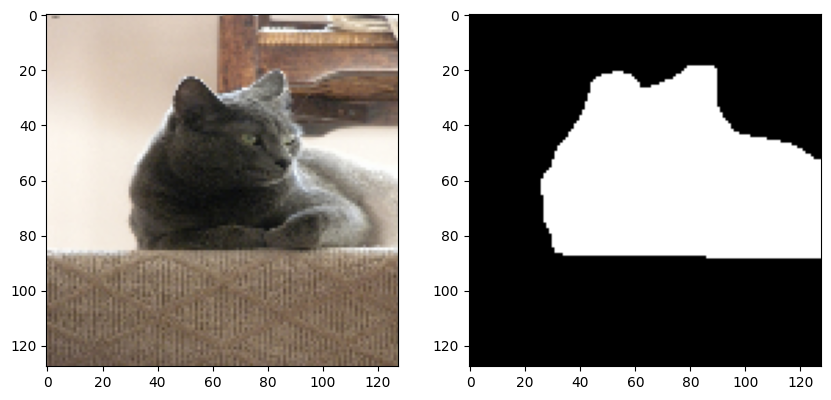

In [138]:
image_batch= next(iter(train_ds))
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(np.transpose(np.array(image_batch[0][0]),(1,2,0)))
plt.subplot(122)
plt.imshow(np.array(image_batch[1][0]),'gray')